In [14]:
import numpy as np
import pandas as pd
import pickle

In [4]:
import re

from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, accuracy_score
from sklearn.naive_bayes import BernoulliNB

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
snow=SnowballStemmer("english")
def snowball_tokens2(text):
    text_processed = re.sub(r'[^A-Za-z]', ' ', text).split()
    tokens = [snow.stem(word) for word in text_processed]
    return tokens

In [9]:
canada_df = pd.read_csv('..\data\canada_subreddit_comments.csv')

In [10]:
custom_stopwords= stopwords.words('english')
custom_stopwords.extend(['people', 'like', 'canada'])
custom_stopwords = [snow.stem(word) for word in custom_stopwords]
#I'm cheating and adding a few more stopwords here that I identfied as highly shared between both subreddits
#that I didn't identify until after doing some more analysis on top tokens

extra_stopwords=['get', 'would', 'gt', 'one', 'go', 'make', 
                 'actual', 'also', 'back', 'us', 'use', 'could', 'say', 'said', 'see', 'back', 'come',
                'canadian', 'look']

custom_stopwords.extend(extra_stopwords)

In [11]:
X=canada_df['body_processed']
y=canada_df['subreddit_bin']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=1920)

In [12]:
bnb_final= Pipeline([('cv', CountVectorizer(tokenizer=snowball_tokens2,
                                            max_features=4000,
                                            stop_words=custom_stopwords,
                                            binary=True)), 
                     ('bnb', BernoulliNB())])

In [13]:
bnb_final.fit(X_train, y_train);

D:\Applications\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['r', 'v'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


In [15]:
# pickle export

pickle.dump(bnb_final, open("final_model.p", "wb"))


# Final Model Analysis

Recall that by grid search, we identified a final model to be a Binomial Naive Bayes classifier, with the binary  CountVectorizer taking 4000 features, stopwords removed and a stemming tokenizer. Let's also recall that a positive result corresponds to a comment being classified in r\OnGuardForThee, and a negative result corresponds to being classified in r\Canada.

In [11]:
bnb_final.score(X_train, y_train)

0.6841337224728045

In [12]:
bnb_final.score(X_test, y_test)

0.6146040588937525

Also recall that we like analyzing longer comments.

In [13]:
X_test_long = X_test[X_test.str.split().str.len() > 50]
y_test_long = y_test[X_test.str.split().str.len() > 50]

In [14]:
bnb_final.score(X_test_long, y_test_long)

0.6319444444444444

And let's keep our baseline here for reference.

In [15]:
y_test.value_counts(normalize=True)

1    0.503979
0    0.496021
Name: subreddit_bin, dtype: float64

In [207]:
y_test.value_counts()

1    2533
0    2493
Name: subreddit_bin, dtype: int64

In [16]:
y_test.shape

(5026,)

## Classification Metrics

Let's build a confusion matrix and take a look at our metrics.

In [17]:
preds=bnb_final.predict(X_test)

In [18]:
final_cm=confusion_matrix(y_test, preds)
tn, fp, fn, tp = final_cm.ravel()

In [19]:
final_cm

array([[1782,  711],
       [1226, 1307]], dtype=int64)

In [20]:
tn+fn

3008

In [21]:
tp + fp

2018

Despite that the data is split about 50/50 between OGFT and Canada comments, it's guessing about 60% of the comments are from r/Canada, and 40% of the comments are from OGFT.

### Accuracy

In [22]:
accuracy_score(y_test, preds)

0.6146040588937525

### Recall/Sensitivity

In [23]:
recall_score(y_test, preds)

0.5159889459139361

We're correctly identifying 51% the OGFT posts. This isn't great!

### Specificity

In [24]:
tn/(tn + fp)

0.7148014440433214

Specificity is doing better: we're hitting 71% of the Canada posts.

### Precision

In [25]:
precision_score(y_test, preds)

0.6476709613478692

Our model is 64.8% precise at identifying r/OnGuardForThee posts.

In [26]:
(tn)/(tn+fn)

0.5924202127659575

It's 59% precise at identifying r/Canada posts.

### F1 Score

In [27]:
f1_score(y_test, preds)

0.5743792573060865

These aren't great results, but they are consistently above the baseline. They also confirm some of the things that we observed in the data exploration. Overall, it seems that the model is much better at identifying r/Canada posts than r/OnGuardForThee
 
Though the results aren't necessarily great, given the wide overlap in subject matter and consistently above baseline performance, I think that our model is grabbing onto something interesting here.

## Classification metrics for long comments

Is there a length threshold for comments that gives us better accuracy? We previously showed that the model is more accurate on comments of >50 words. Let's see if we can identify a word length cutoff that maximizes accuracy.

In [ ]:
X_test_long = X_test[X_test.str.split().str.len() > 50]
y_test_long = y_test[X_test.str.split().str.len() > 50]

In [145]:
acc_score=0
threshold=0
for i in range(0,250):
    print(i)
    X_test_l=X_test[X_test.str.split().str.len() > i]
    y_test_l = y_test[X_test.str.split().str.len() > i]
    i_acc=bnb_final.score(X_test_l, y_test_l)
    if i_acc > acc_score:
        acc_score=i_acc
        threshold = i

print(f"Best accuracy of {acc_score} is achieved predicting comments of length {threshold} words or greater")

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
Best accuracy of 0.6389085754783841 is achieved predicting comments of length 20 words or greater


So we get a an accuracy improvement of up to 0.639% (from 0.614) if we restrict to comments that have more than 20 words. Let's rerun our classification metrics for just this subset.

In [161]:
X_test_long = X_test[X_test.str.split().str.len() > 20]
y_test_long = y_test[X_test.str.split().str.len() > 20]

In [167]:
X_test_long.shape

(2822,)

In [181]:
y_test_long.value_counts(normalize=True)

1    0.515946
0    0.484054
Name: subreddit_bin, dtype: float64

In [209]:
y_test_long.value_counts()

1    1456
0    1366
Name: subreddit_bin, dtype: int64

This is a sample test set with near 3000 values, and close to 50% balance between classes. So our stratification isn't too skewed by the wordcount restriction.

In [168]:
preds_long=bnb_final.predict(X_test_long)

In [183]:
cm_long=confusion_matrix(y_test_long, preds_long)
tn_l, fp_l, fn_l, tp_l = cm_long.ravel()

In [176]:
cm_long

array([[863, 503],
       [516, 940]], dtype=int64)

In [184]:
tn_l + fn_l

1379

In [185]:
tp_l + fp_l

1443

The predictions for this test set are much more balanced -- it's guessing categories much closer to their actual proportions.

### Accuracy

In [170]:
accuracy_score(y_test_long, preds_long)

0.6389085754783841

### Recall

In [177]:
recall_score(y_test_long, preds_long)

0.6456043956043956

### Specificity

In [186]:
tn_l/(tn_l + fp_l)

0.6317715959004392

### Precision

In [179]:
precision_score(y_test_long, preds_long)

0.6514206514206514

The model is 65% precise at identifying long comments to be in r/OnGuardForThee.

In [187]:
tn_l/(tn_l+fn_l)

0.6258158085569253

It's 63% precise at identifying r/Canada posts.

### F1 Score

In [188]:
f1_score(y_test_long, preds_long)

0.6484994825802001

It seems that restricting our test set to comments of greater than 20 words significantly improves performance. All metrics except specificity show improvement, some significantly. This seems to imply that the model was disproportionately guessing comments of 20 words or under to be in r/Canada, increasing specificity at the expense of everything else.

Though not included here, training our model (in it's current form) on exclusively long comments actually slightly reduces performance. It seems like the model is "learning" something useful from smaller comments that's useful for predicting larger ones.

## A Quick Analysis of Short Comments

In [189]:
X_test_short = X_test[X_test.str.split().str.len() <= 20]
y_test_short = y_test[X_test.str.split().str.len() <= 20]

In [191]:
X_test_short.shape

(2204,)

In [192]:
y_test_short.value_counts(normalize=True)

0    0.511343
1    0.488657
Name: subreddit_bin, dtype: float64

In [210]:
y_test_short.value_counts()

0    1127
1    1077
Name: subreddit_bin, dtype: int64

In [193]:
preds_short=bnb_final.predict(X_test_short)

In [196]:
cm_short=confusion_matrix(y_test_short, preds_short)
tn_s, fp_s, fn_s, tp_s = cm_short.ravel()

In [195]:
cm_short

array([[919, 208],
       [710, 367]], dtype=int64)

In [197]:
tp_s + fp_s

575

In [198]:
tn_s + fn_s

1629

As predicted, the model is significantly skewed towards guessing that short comments are from r/Canada, despite them being near balanced classes.

In [199]:
accuracy_score(y_test_short, preds_short)

0.5834845735027223

In [200]:
recall_score(y_test_short, preds_short)

0.34076137418755803

**Specificity**

In [201]:
tn_s/(tn_s+fp_s)

0.8154392191659272

In [202]:
precision_score(y_test_short, preds_short)

0.6382608695652174

**Canada precision**

In [203]:
tn_s/(tn_s+fn_s)

0.5641497851442603

In [205]:
f1_score(y_test_short, preds_short)

0.44430992736077485

## Analysis/Exploration

I'm particularly interested in comments that our model assigned high probabilities to. Let's investigate some such comments.

In [28]:
predict_probs=bnb_final.predict_proba(X_test)

In [29]:
predict_probs.shape

(5026, 2)

In [30]:
predict_probs[:,0]

array([0.89153374, 0.77489858, 0.69960435, ..., 0.35682451, 0.79064755,
       0.73541651])

In [31]:
comment_probs=pd.DataFrame(X_test)

In [32]:
comment_probs['canada_prob']=predict_probs[:,0]
comment_probs['ogft_prob']=predict_probs[:,1]
comment_probs['subreddit']=y_test.map({0:'r/canada', 1:'r/onguardforthee'})
comment_probs['y_pred']=preds
comment_probs['y_true']=y_test
comment_probs['correct']= comment_probs['y_pred']==comment_probs['y_true']

In [33]:
comment_probs

,body_processed,canada_prob,ogft_prob,subreddit,y_pred,y_true,correct
2494,"Hah, so damn sensitive. Where have I insulted ...",0.891534,0.108466,r/onguardforthee,0,1,False
4753,I'm glad she is at least free of that pain and...,0.774899,0.225101,r/onguardforthee,0,1,False
12281,"I got an idea, lets ban murder all together. T...",0.699604,0.300396,r/canada,0,0,True
10206,The flu causes all those things too. So does e...,0.981876,0.018124,r/canada,0,0,True
5494,"yeah, you're right. Canadians who were born he...",0.393335,0.606665,r/onguardforthee,1,1,True
...,...,...,...,...,...,...,...
17690,"I never want to deal with US style Healthcare,...",0.245613,0.754387,r/canada,1,0,False
5629,Sooooo CBC?,0.710833,0.289167,r/onguardforthee,0,1,False
6099,Source: http://projects.thestar.com/canadas-co...,0.356825,0.643175,r/onguardforthee,1,1,True
11159,It seems like a radical idea to decriminalize ...,0.790648,0.209352,r/canada,0,0,True


Let's look at comments that the model was very certain about. Let's see what was above a 95% probability threshold.

In [34]:
comment_probs[comment_probs['ogft_prob'] >=0.95].sort_values('ogft_prob').tail(10)

,body_processed,canada_prob,ogft_prob,subreddit,y_pred,y_true,correct
8775,I absolutely agree with you on all points. Tru...,7.777650e-09,1.0,r/onguardforthee,1,1,True
1946,&gt; Maybe it's because everyone is cooped up ...,5.241745e-09,1.0,r/onguardforthee,1,1,True
10980,"&gt; The mayor of Summerland, B.C., is declini...",4.363294e-09,1.0,r/canada,1,0,False
5536,You are right about the attitude towards addic...,3.440726e-09,1.0,r/onguardforthee,1,1,True
7273,I was one of the founding mods of /canada- I d...,1.339018e-09,1.0,r/onguardforthee,1,1,True
7930,""" Dude wore MAGA hats and worshipped Trump. ""...",5.718436e-11,1.0,r/onguardforthee,1,1,True
1638,"yeah i know, theyve done that to me countless ...",1.718890e-11,1.0,r/onguardforthee,1,1,True
15081,&gt;your conflating a deference in politics wi...,4.287370e-13,1.0,r/canada,1,0,False
7466,If the UCP/right wing/alt-right think we're go...,9.248932e-15,1.0,r/onguardforthee,1,1,True
4926,The only way to effectively stop divisive dirt...,3.152664e-15,1.0,r/onguardforthee,1,1,True


In [35]:
comment_probs[comment_probs['ogft_prob'] >=0.95]['correct'].value_counts(normalize=True)

True     0.745098
False    0.254902
Name: correct, dtype: float64

In [36]:
comment_probs[comment_probs['canada_prob'] >=0.95]

,body_processed,canada_prob,ogft_prob,subreddit,y_pred,y_true,correct
10206,The flu causes all those things too. So does e...,0.981876,0.018124,r/canada,0,0,True
19690,Unless I'm getting table service or I'm waited...,0.978532,0.021468,r/canada,0,0,True
16462,This is what happens when you have wolves in c...,0.980541,0.019459,r/canada,0,0,True
20023,A friend of mine just told me that if you show...,0.985260,0.014740,r/canada,0,0,True
17290,&gt;The CRTC has sided with Canada’s largest w...,0.991513,0.008487,r/canada,0,0,True
...,...,...,...,...,...,...,...
17433,"So tangentially, is there data on people who o...",0.958211,0.041789,r/canada,0,0,True
16626,let them use their cell phone profits to pay f...,0.963772,0.036228,r/canada,0,0,True
1659,&gt;Diversify Yo Bonds\n\n- Wu-Tang Financial,0.958520,0.041480,r/onguardforthee,0,1,False
15006,I totally agree with you that we’ve become nor...,0.999865,0.000135,r/canada,0,0,True


In [37]:
comment_probs[comment_probs['canada_prob'] >=0.95]['correct'].value_counts(normalize=True)

True     0.731563
False    0.268437
Name: correct, dtype: float64

Of the 5030 test values, about 850 were classified as having a 95% probability of belonging to a given category.
- For r/onguardforthee, 74% of these predictions were correct.
- For r/canada, 73% of these predictions were correct.

Let's crank the threshold up even further.

In [133]:
comment_probs[comment_probs['ogft_prob'] >=0.999999]

,body_processed,canada_prob,ogft_prob,subreddit,y_pred,y_true,correct
437,"""Fiscally Conservative"" is a myth and a fairly...",6.117520e-07,0.999999,r/onguardforthee,1,1,True
4926,The only way to effectively stop divisive dirt...,3.152664e-15,1.000000,r/onguardforthee,1,1,True
15081,&gt;your conflating a deference in politics wi...,4.287370e-13,1.000000,r/canada,1,0,False
5189,Are the pollsters not calling them? I'm so sic...,7.321075e-07,0.999999,r/onguardforthee,1,1,True
8281,And see this is where we differ ; you are scar...,1.168728e-07,1.000000,r/onguardforthee,1,1,True
4659,"No kidding. r/Canada is still going strong, to...",3.349545e-08,1.000000,r/onguardforthee,1,1,True
9115,Antifa is the propaganda boogeyman of the alt ...,5.771782e-07,0.999999,r/onguardforthee,1,1,True
7273,I was one of the founding mods of /canada- I d...,1.339018e-09,1.000000,r/onguardforthee,1,1,True
7184,"I don't know what it's like to raise a child, ...",4.249685e-08,1.000000,r/onguardforthee,1,1,True
6875,&gt;Premier Ford has a net favourability ratin...,1.448484e-07,1.000000,r/onguardforthee,1,1,True


In [135]:
comment_probs[comment_probs['ogft_prob'] >=0.999999].shape

(31, 7)

In [134]:
comment_probs[comment_probs['ogft_prob'] >=0.999999]['correct'].value_counts(normalize=True)

True     0.903226
False    0.096774
Name: correct, dtype: float64

In [136]:
comment_probs[comment_probs['canada_prob'] >=0.999999]

,body_processed,canada_prob,ogft_prob,subreddit,y_pred,y_true,correct
19058,Serious answer? \n\n1. Huawei is the only vend...,1.0,4.785689e-08,r/canada,0,0,True


In [137]:
comment_probs[comment_probs['canada_prob'] >=0.999999].shape

(1, 7)

In [138]:
comment_probs[comment_probs['canada_prob'] >=0.999999]['correct'].value_counts(normalize=True)

True    1.0
Name: correct, dtype: float64

22+1= comments were predicted as having almost near certainty to belong in a given category (>0.999999 chance) - 22 in OnGuardForThee, 1 in Cananada. This is interesting, given that the model is much better at predicting if a post is in r/Canada.

## Representative comments

Let's take a look at the high certainty comments that were predicted correctly.

In [70]:
top_can=comment_probs[(comment_probs['canada_prob'] >=0.999999 ) &(comment_probs['correct']==1)]['body_processed']
top_ogft=comment_probs[(comment_probs['ogft_prob'] >=0.999999) & (comment_probs['correct']==1)]['body_processed']

In [72]:
top_can.str.split().str.len().mean()

465.0

In [73]:
top_ogft.str.split().str.len().mean()

193.17857142857142

In [74]:
top_can.shape

(1,)

In [75]:
top_ogft.shape

(28,)

Recall that our average wordcount was around 44 words, while these comments have an average wordcount of over 250. So it seems that longer comments have a higher chance of being properly classified, or at least our model weights wordcount when assigning a category.

Let's also look at comments that the model foud extremely difficult to predict, where the probability of them being in a given subreddit was assigned to be $50 \pm 0.001\%$.

In [78]:
uncertain_comments =comment_probs[(comment_probs['canada_prob'] >=0.499)& (comment_probs['ogft_prob'] >=0.499)]

In [81]:
uncertain_comments.shape

(9, 7)

In [79]:
uncertain_comments['body_processed'].str.split().str.len().mean()

27.11111111111111

We have nine such comments. On average, they each contain 27 words. Seven of these were actually identified correctly, but that's mostly luck.

### Highest Probability r/OnGuardForThee Comments

In [71]:
for comment in top_ogft:
    print(comment + "\n ---------------------------")

"Fiscally Conservative" is a myth and a fairly new concept perpetuated by the right in an attempt to garner socially liberal votes and make people think they're doing something positive.

A government either knows how to handle money responsibly, or they don't. Funding social programs is a fiscally responsible initiative. It brings economic prosperity by boosting up marginalized populations so that they're contributing to a local and national economy. It's been proven by economic theory countless times.

Tax breaks for no reason to profitable corporations who hoard money in tax havens is not fiscally responsible. It's corporate welfare. Neither is cutting funding to education and other necessary items for a society to function. Austerity measures are a proven failure time and time again, but historically, Conservatives view it as an economic plan to recovery in recession (or any time for that matter).

"Fiscally Conservative" is almost becoming a slur to describe the "I got mine, now y

### Highest Probability r/Canada Comments

In [76]:
for comment in top_can:
    print(comment + "\n ---------------------------")

Serious answer? 

1. Huawei is the only vendor that is currently able to roll out 5G tech on a commercial scale and at a much cheaper price than its competitors. You can blame tech stealing or whatever, but those are the facts. Banning Huawei would essentially give the rest of the world a head start in the 5G game. 

2. Huawei is already being used extensively in 4G networks by Telus and Bell. So if we ban Huawei entirely, we would have to rip out a lot of the current mobile infrastructure as well.

3. There is currently no evidence of any backdoors to Huawei equipment. Of course this doesn't mean that they can't do it later on, but everything so far including the Nortel case and the microchip case by bloomberg have basically all been based on hearsay. 

4. Huawei has multi-million dollar research agreements with UT and UBC. 

Or if you're r/Canada:

1. Trudeau has been bought by the Chinese. 

What are the security risks:

1. Huawei has a history of cyber-industrial espionage. I perso

### Uncertainly classified comments

In [88]:
for comment in uncertain_comments['body_processed']:
    print(comment + "\n ---------------------------")

It's there for people on the fence thinking about the value of their savings and feeling any guilt for not donating. They actually have donated via the method I mentioned above so there should be no guilt for refusing to donate. That also allows them to complain about the situation regardless of not fitting OP's definition of what a donation is.
 ---------------------------
Once again. You said that for the past 60 days, give or take, Trudeau has been failing. 10 days ago the WHO praised the response. You're an idiot.
 ---------------------------
I've never seen Cortland over here, but I'll keep the name in mind.  Thanks!
 ---------------------------
That's like saying "Let's steal all the stop signs at this intersection and see how long it takes before people don't stop there."

You can't trick people into thinking you've done a thing by actually doing the thing. That's not a trick. It's just you doing the thing.
 ---------------------------
It's worth noting that UBC only allowed the

## Token Analysis (By Model Probability)

In [52]:
ogft_log_probs=bnb_final[1].feature_log_prob_[1]
canada_log_probs=bnb_final[1].feature_log_prob_[0]

In [53]:
bnb_final[1].feature_count_[1]

array([11., 12.,  7., ...,  6., 48., 10.])

In [54]:
token_probs = pd.DataFrame(bnb_final[0].get_feature_names())

In [55]:
token_probs['ogft_log_prob']= ogft_log_probs.transpose()
token_probs['canada_log_prob']= canada_log_probs.transpose()

In [56]:
token_probs.columns = ['token', "ogft_log_prob", "canada_log_prob"]

In [57]:
token_probs['odds_gap'] = np.abs(token_probs['ogft_log_prob']-token_probs['canada_log_prob'])

In [58]:
token_probs['favoured']=token_probs.apply(lambda x: "r/OnGuardForThee" if x['ogft_log_prob'] > x['canada_log_prob'] else "r/Canada", axis=1)

In [59]:
token_probs['ogft_count']=bnb_final[1].feature_count_[1]
token_probs['canada_count']=bnb_final[1].feature_count_[0]

In [60]:
token_probs.set_index('token', inplace=True)

In [61]:
token_probs= token_probs[['ogft_count', 'canada_count', 'ogft_log_prob', "canada_log_prob", "odds_gap", "favoured"]]

## Unique/strongly favoured tokens

**Idea**: Let's look at tokens that were modeled to strongly favour one subreddit over the other by looking by the gap in odds between them.

### r/Canada 

In [62]:
token_probs[token_probs['favoured']=='r/Canada'].sort_values('odds_gap', ascending=False).head(50)

,ogft_count,canada_count,ogft_log_prob,canada_log_prob,odds_gap,favoured
token,,,,,,
impair,0.0,16.0,-8.935640,-6.087042,2.848598,r/Canada
meng,0.0,13.0,-8.935640,-6.281198,2.654442,r/Canada
marineland,0.0,10.0,-8.935640,-6.522360,2.413280,r/Canada
burger,1.0,21.0,-8.242493,-5.829213,2.413280,r/Canada
disciplin,0.0,9.0,-8.935640,-6.617670,2.317970,r/Canada
naturopath,0.0,8.0,-8.935640,-6.723031,2.212609,r/Canada
telecommun,0.0,8.0,-8.935640,-6.723031,2.212609,r/Canada
brazilian,0.0,8.0,-8.935640,-6.723031,2.212609,r/Canada
taxi,0.0,8.0,-8.935640,-6.723031,2.212609,r/Canada


There's a few of these that can be sorted into categories.

The most skewed token by odds is **impair**. Apparently r/Canada is much more concerned about impaired driving issues than OnGuardForThee. A quick search reveals that they had a lot of discussion about impaired driving laws as relating to weed legalization.

Issues to relating to China: "meng", (Meng Whenzhou), "xi" (Xi JingPing), "huawei" and "taiwan".

"marineland" and "aquarium". Niagara's controversial aquarium.

Telecommmunications: "telecommun", "nortel", "wireless", "unlimit" (probably). Complaining about the telecommunications cartel is a long standing Canadian pastime.

Real estate: "realtor", "launder", "condo", "transcat".

In general, our model thinks that r\Canada likes talking about China-Canada relations and business issues.

I'm really not sure what's going on with the "burger" keyword, so let's do a quick search and see what they're talking about.

**Burger references in training data**

In [143]:
mask=X_train.str.contains("burger")

for cmt in X_train[mask]:
    print(cmt+"\n ______________________")

Something to be said for no cholesterol though I think.  I wish they'd pick a random group of non-insulin resistant people with normal cholesterol/body weight and give them some beyond burgers to eat and give a control group some beef burgers and then check out their cholesterol after a period of time.  It doesn't seem like it should be that difficult
 ______________________
More like Canada’s most iconic brand has now decided to butcher hamburgers along with the rest of their terrible food.
 ______________________
Gotta add pork fat or something or that is gonna be one dry burger.

Plus fat is good for you.
 ______________________
Ya'll can't toast and butter a bagel correctly. 

Why are you serving burgers and spicy Thai soup?
 ______________________
I'll stick with A&amp;W for my beyond burgers.
 ______________________
Eating beyond burgers is a political statement not a health choice. I wish they would advertise it that way and not confuse the public.
 ______________________
The fa

In [139]:
mask=comment_probs['body_processed'].str.contains("burger")

comment_probs[mask]

,body_processed,canada_prob,ogft_prob,subreddit,y_pred,y_true,correct
17385,"First order of business, eliminate the cheeseb...",0.623524,0.376476,r/canada,0,0,True
15938,"I’m the opposite, I use regular ground beef an...",0.990242,0.009758,r/canada,0,0,True
16095,Tim Horton's was my first job too :) Not sur...,0.994089,0.005911,r/canada,0,0,True
16104,It shocks me that anyone would eat at Tim Hort...,0.999866,0.000134,r/canada,0,0,True
2153,People get veggie burgers from supermarkets. S...,0.992743,0.007257,r/onguardforthee,0,1,False
6767,And the inevitable and necessary drop in servi...,0.878653,0.121347,r/onguardforthee,0,1,False
6795,"real people: people that goto ""Fordfest"" for a...",0.981132,0.018868,r/onguardforthee,0,1,False
13811,I went to one last week and the Angus burger t...,0.996758,0.003242,r/canada,0,0,True


Burger chat was classified with an accuracy of 0.625%, so maybe it's on to something.

### r/OnGuardForThee

In [63]:
token_probs[token_probs['favoured']=='r/OnGuardForThee'].sort_values('odds_gap', ascending=False).head(50)

,ogft_count,canada_count,ogft_log_prob,canada_log_prob,odds_gap,favoured
token,,,,,,
metacanada,63.0,0.0,-4.776757,-8.920255,4.143498,r/OnGuardForThee
leftist,30.0,0.0,-5.501653,-8.920255,3.418602,r/OnGuardForThee
onguardforthe,18.0,0.0,-5.991201,-8.920255,2.929054,r/OnGuardForThee
mod,51.0,3.0,-4.984397,-7.533961,2.549564,r/OnGuardForThee
canadapolit,11.0,0.0,-6.450734,-8.920255,2.469522,r/OnGuardForThee
gavin,10.0,0.0,-6.537745,-8.920255,2.382510,r/OnGuardForThee
brigad,10.0,0.0,-6.537745,-8.920255,2.382510,r/OnGuardForThee
denier,9.0,0.0,-6.633055,-8.920255,2.287200,r/OnGuardForThee
levant,9.0,0.0,-6.633055,-8.920255,2.287200,r/OnGuardForThee


The most skewed token for r/OGFT is **metacanada**. This is the name of an alt-right Canadian subreddit. In general, this list is full of tokens related to metacommentary about other aspects of reddit. "onguardforthe", "mod", "canadapolit", and "subreddit" are all tokens related to commentary on reddit itself, or other reddit communities.

Without exception, ever token on this list that's related to a person's name is a loud, online conservative media commentator. "levant" (Ezra Levant), "gavin" "mcinn" (Gavin McInnes), "jordan" "peterson" (Jordan Peterson).

Loaded language that's characteristic of leftist online social discussion. "denier/denial", "bigot", "intoler", "lick" (typically as in bootlicker), "misognyis/misogynist", "shill", "rag", "redneck", "incel".

Left wing keywords like "leftist" and "socialist".

References to conservative groups: "maga", "republican", "yellow", "vest"

In other words, the model is pretty sure that if you're criticizing/discussing some other subreddit or conservative group, you're probably making an r/OnGuardForThee post.

Note: Keywords complaining about conservative issues takes up far more of this leaderboard than tokens relating to leftist policy. So does meta-discussion about more right wing Canadian subreddits. This could be evidence towards the pretty common anecdotal complaint that online left wing discussion spends more time hate reading/discussing things they don't like than on policy goals.

These are kind of outliers, though. Many of these are words that just weren't seen in the comment set of one subreddit or the other. What about more common words?

## Skewed Common Words

Let's look at tokens with a large odds gap that appeared in at least 100 comments in each subreddit in the training set.

In [64]:
mask=(token_probs['favoured']=='r/Canada') & (token_probs['ogft_count'] >= 100) & (token_probs['canada_count'] >= 100)

token_probs[mask].sort_values('odds_gap', ascending=False).head(25)

,ogft_count,canada_count,ogft_log_prob,canada_log_prob,odds_gap,favoured
token,,,,,,
buy,111.0,184.0,-4.217141,-3.699900,0.517242,r/Canada
hous,101.0,162.0,-4.310668,-3.826505,0.484162,r/Canada
cost,128.0,191.0,-4.075828,-3.662760,0.413068,r/Canada
month,102.0,151.0,-4.300911,-3.896375,0.404536,r/Canada
compani,146.0,192.0,-3.945208,-3.657565,0.287643,r/Canada
home,130.0,170.0,-4.060443,-3.778592,0.281851,r/Canada
ask,139.0,178.0,-3.993998,-3.732870,0.261128,r/Canada
law,170.0,217.0,-3.793977,-3.535760,0.258216,r/Canada
lol,106.0,135.0,-4.262811,-4.007601,0.255211,r/Canada


Common economic words seem to be more strongly weighted to r/Canada.

In [65]:
mask=(token_probs['favoured']=='r/OnGuardForThee') & (token_probs['ogft_count'] >= 100) & (token_probs['canada_count'] >= 100)

token_probs[mask].sort_values('odds_gap', ascending=False).head(25)

,ogft_count,canada_count,ogft_log_prob,canada_log_prob,odds_gap,favoured
token,,,,,,
conserv,507.0,169.0,-2.705159,-3.784457,1.079298,r/OnGuardForThee
vote,401.0,189.0,-2.939188,-3.673231,0.734043,r/OnGuardForThee
elect,293.0,160.0,-3.252061,-3.838851,0.586790,r/OnGuardForThee
left,187.0,103.0,-3.699198,-4.275865,0.576666,r/OnGuardForThee
post,242.0,145.0,-3.442579,-3.936649,0.494070,r/OnGuardForThee
power,168.0,102.0,-3.805742,-4.285526,0.479785,r/OnGuardForThee
liber,294.0,180.0,-3.248665,-3.721758,0.473093,r/OnGuardForThee
social,175.0,108.0,-3.765156,-4.228908,0.463751,r/OnGuardForThee
support,267.0,165.0,-3.344653,-3.808268,0.463614,r/OnGuardForThee


Well, we can see that I messed up the regex removing URL's.

 Other than that, we can see a stronger tendence towards specifically political/regional discussion. Lots of political keywords, lots of names of provinces.
 
We can also see that the odds gaps for favoured OnGuardForThee words is larger than those of r/Canada. E.g., the top 50 gaps with no filter range from 4.15-1.59 , while for r/Canada they range from 2.84-1.40. Similarly, when adding a minimum token count threshold, the largest 25 gaps in favour of OnGuardForThee range from 1.08-0.28, while the largest 25 in favour of r/Canada range from 0.53-0.13.

I find this interesting, because the model overall favours r/Canada -- recall that it assigned 60% of posts to r/Canada. Despite this, the keywords that are associated to be favoured by OnGuardForThee seem to be assigned a more significant weight.

In [66]:
token_probs['favoured'].value_counts()

r/OnGuardForThee    2057
r/Canada            1943
Name: favoured, dtype: int64

There's more tokens that are classified as more strongly weighted for OnGuardForThee, too! However, now let's look at some statistics aggregated by sum.

In [67]:
token_probs[['ogft_count','canada_count', 'ogft_log_prob', 'canada_log_prob','favoured']].groupby('favoured').sum()

,ogft_count,canada_count,ogft_log_prob,canada_log_prob
favoured,,,,
r/Canada,43704.0,55946.0,-12616.586240,-11844.073700
r/OnGuardForThee,77243.0,56138.0,-12151.230407,-13124.613989


This is a little hard to interpret (and yes, I tried histograms, but it was mostly too minute to visualize). But it appears to show that over all r/canada favoured words, the sums of the canada_log_probs are larger than the sum of the otfg log probabilities of the onguardforthee favoured tokens. That is, despite OGFT having the more noticible gaps in probability weights, the total sum of probabilities of words that skew towards r/Canada is higher.

C:\Users\Patrick Dornian\AppData\Roaming\Python\Python38\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Patrick Dornian\AppData\Roaming\Python\Python38\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 0, 'Log Odds')

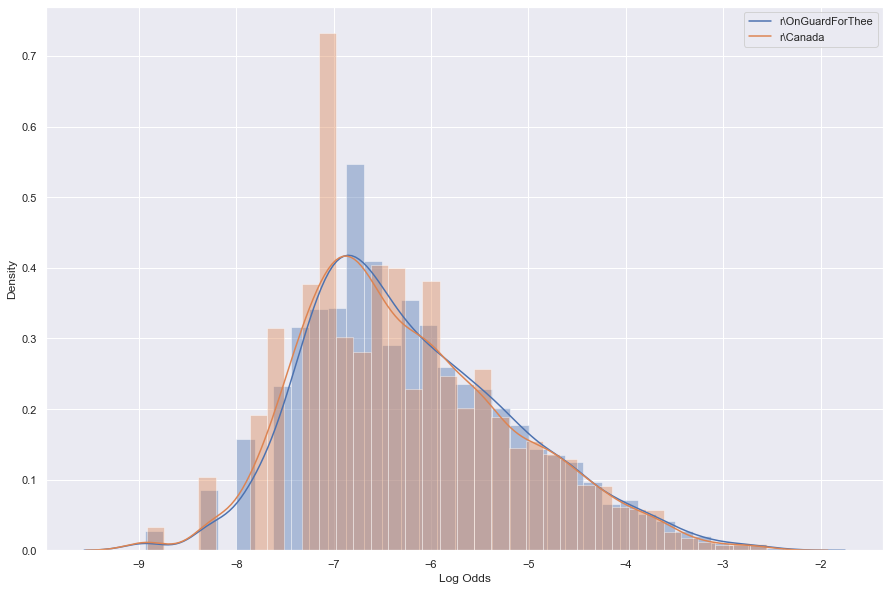

In [132]:
fig, ax=plt.subplots(figsize=(15,10))
sns.set_theme()
sns.distplot(token_probs['ogft_log_prob'])
sns.distplot(token_probs['canada_log_prob'])
ax.legend(['r\OnGuardForThee', 'r\Canada'])
plt.xlabel("Log Odds")


# Conclusions

The final model chosen was a Bernoulli naive Bayes binary classifer, using 4000 features learned from the training set.

We evaluated the model on a test set using standard classification metrics. Additionally, results were recorded for the classification performance of the test set partitioned into comments of greater than 20 words (long comments), and comments 20 or less words (short comments).

|                                  | All comments | Long Comments (>20 words) | Short Comments (<=20 words) |
|---------------------------------:|:------------:|:-------------------------:|:---------------------------:|
|                   Total Comments |     5016     |            2822           |             2204            |
|          Actual r/OnGuardForThee |     2533     |            1456           |             1127            |
|                  Actual r/Canada |     2493     |            1366           |             1077            |
|       Predicted r/OnGuardForThee |     2018     |            1443           |             575             |
|               Predicted r/Canada |     3008     |            1337           |             1629            |
|                   Accuracy Score |    0.6146    |           0.6389          |            0.5835           |
|                     Recall Score |    0.5160    |           0.6456          |            0.3708           |
|                Specificity Score |    0.7148    |           0.6318          |            0.8154           |
| Precision (OnGuardForThee) Score |    0.6477    |           0.6514          |            0.6383           |
|         Precision (Canada) Score |    0.5924    |           0.6258          |            0.5641           |
|                         F1 Score |    0.5744    |           0.6485          |            0.4443           |

These conclusions imply that the model would be best used for classifying long comments-- it has adequate performance within that category. 

The model's performance on short comments is highly skewed towards classifying things to be in r/Canada. Though it's accuracy is still above baseline, it's bias makes me recommend against using it to classify such comments.

Though the model is not particularly accurate, this is an inherently messy classification subject. I think that if used heuristically and with an understanding of it's limitations, it could still prove to be a useful classifier.

# Epilogue 

Testing functions for putting this online.

In [20]:
sample_post="I hate conservatives they are dumb bithces"

In [29]:
bnb_final.predict([sample_post])

array([1], dtype=int64)

In [26]:
bnb_final.predict_proba([sample_post])[0,0]

0.2481948964306757

In [30]:
def pred_post(text, model):
    label_map=['r/Canada', 'r/OnGuardForThee']
    post=[text]
    prediction=model.predict([text])[0]
    pred_text=label_map[prediction]
    pred_prob=round(model.predict_proba([text])[0,prediction] * 100, 1)
    return f"The model thinks this seems like an {pred_text} post with {pred_prob}% certainty"

In [32]:
pred_post(sample_post, bnb_final)

'The model thinks this is a r/OnGuardForThee post with 75.2% certainty'